# Container Segmentation by Color Image Segmentation

Whenever we see images, it is composed of various elements and objects. In some
circumstance, there might come a time that you would want to extract a certain
object from the image. What would you do? Ah, I know. The first thing you will
think of is to crop it, right? Well, that would somehow work. But there are
irrelevant pixels that would be included, and I know for sure you do not want
that. What if I tell you that we can obtain objects of interest using image
processing techniques?

Welcome to Image segmentation using Python.

## Image Segmentation

It is the process of dividing an image into its constituent parts or objects.
Common techniques include edge detection, boundary detection, thresholding,
region based segmentation, among others. For this work, let us focus on
segmenting our images using Color Image Segmentation through the HSV color
space. Later, we'll use region based segmentation.

But before we do that, install the following libraries, and follow along.

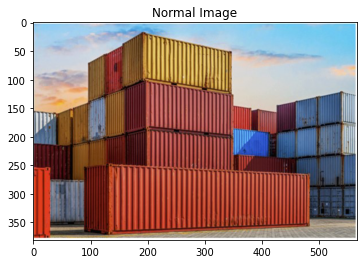

In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

container = imread('images/foto11.jpg')
plt.imshow(container)
plt.title('Normal Image')
plt.show()

### Simple Linear Iterative Clustering

 This filter creates superpixels based on k-means clustering.

Superpixels are small cluster of pixels that share similar properties.
Superpixels simplifies images with a great number of pixels making them more
easy to be treated in many domains (computer vision, pattern recognition and
machine intelligence). GIMP's aim is more humble: create a posterization effect.

k-means clustering is one of the most used algorithms to create superpixels.
Superpixel color is the mean of pixels color in the corresponding region. 

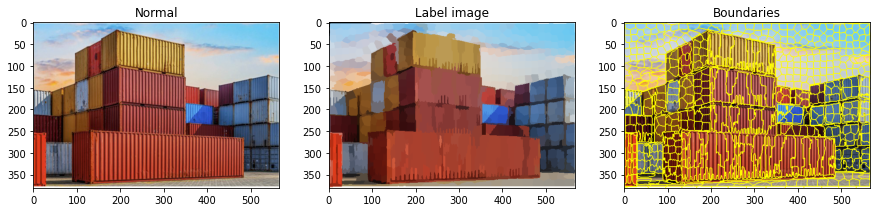

In [2]:
# Importing required libraries
from skimage.segmentation import slic, mark_boundaries
from skimage.data import astronaut
from skimage.color import rgb2hsv, rgb2gray, label2rgb
from skimage import data, img_as_float

 
# We need to have the image as float
container = img_as_float(container)
 
# Applying Simple Linear Iterative
# Clustering on the image
# - 50 segments & compactness = 10
container_segments = slic(container,
                          n_segments=1000,
                          compactness=10,
                          start_label=1,sigma=1, 
                          enforce_connectivity=True, 
                          convert2lab=True)
 
# Converts a label image into
# an RGB color image for visualizing
# the labeled regions.
label_container = label2rgb(container_segments,
                            container,
                            kind = 'avg', 
                            bg_label=1)


boundaries_container= mark_boundaries(container, 
                                      container_segments, 
                                      mode='thick')

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(container)
ax[0].set_title('Normal')
ax[1].imshow(label_container)
ax[1].set_title('Label image')
ax[2].imshow(boundaries_container)
ax[2].set_title('Boundaries');

Our goal here is to segment container through the HSV color space. But how? As discussed in my previous articles, HSV stands for Hue, Saturation, and Value, and we shall be using information from this color space in segmenting the image later on.

But before the segmentation process, let us first convert the RGB image in HSV form through this code:

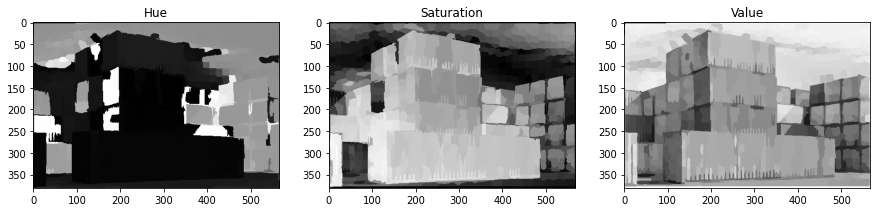

In [3]:
container_hsv = rgb2hsv(label_container)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(container_hsv[:,:,0], cmap='gray')
ax[0].set_title('Hue')
ax[1].imshow(container_hsv[:,:,1], cmap='gray')
ax[1].set_title('Saturation')
ax[2].imshow(container_hsv[:,:,2], cmap='gray')
ax[2].set_title('Value');

Wonderful! We were successful in transforming the image. However, this is not
helpful to us just yet. We need to obtain the intensity values of each HSV
channel to help us in segmenting later. To do that, a colorbar is created
through implementing this code:

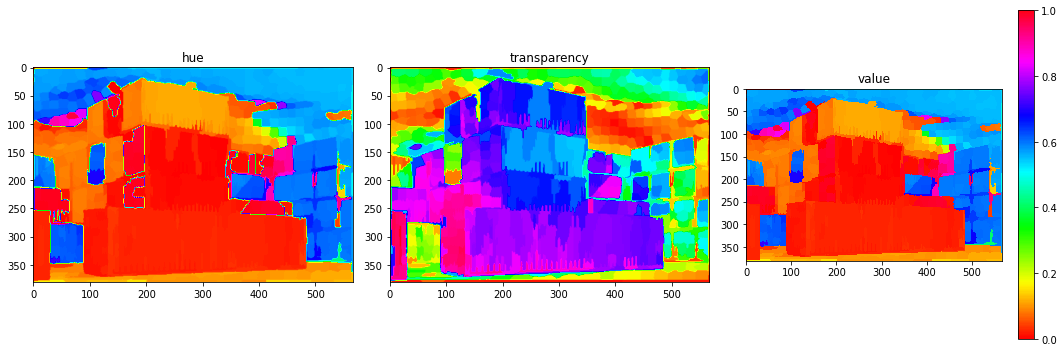

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(container_hsv[:,:,0],cmap='hsv')
ax[0].set_title('hue')

ax[1].imshow(container_hsv[:,:,1],cmap='hsv')
ax[1].set_title('transparency')

ax[2].imshow(container_hsv[:,:,2],cmap='hsv')
ax[2].set_title('value')

fig.colorbar(imshow(container_hsv[:,:,0],cmap='hsv')) 
fig.tight_layout()

Voila! See the colorbar at the right? We will refer to that in segmenting the
bags.

Let us start segmenting

Before implementing the code, let us first set up our thresholds for the masks:

  * Lower Mask (refer to the hue channel)
  * Upper Mask (refer to the hue channel)
  * Saturation Mask (refer to the transparency channel)

In choosing the thresholds, look at the color bar. For example, if we are
segmenting the blue bag. The lower and upper mask values that are appropriate
would be 0.6 and 0.7, respectively. So, in other words, it would only get the
blue pixel values and neglect the rest. After that, the saturation threshold is
decided. This is a bit tricky because you need to consider the colors that are
seen in the object. So, play around with the saturation threshold that would
return the best segmented image.

Now let us code!

Segmenting the blue container, we implement this code:

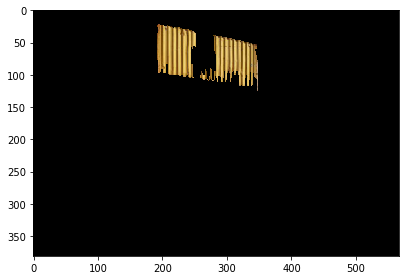

In [5]:
# THIS CODE IS FOR TUNNING (VERY IMPORTANT)!!!!!!!!!!

import numpy as np

#refer to hue channel (in the colorbar)
lower_mask = container_hsv[:,:,0] > 0.1

#refer to hue channel (in the colorbar)
upper_mask = container_hsv[:,:,0] < 0.18

#refer to transparency channel (in the colorbar)
saturation_mask = container_hsv[:,:,1] > 0.57
 
mask = upper_mask*lower_mask*saturation_mask

red = container[:,:,0]*mask
green = container[:,:,1]*mask
blue = container[:,:,2]*mask
container_masked = np.dstack((red,green,blue))
imshow(container_masked)

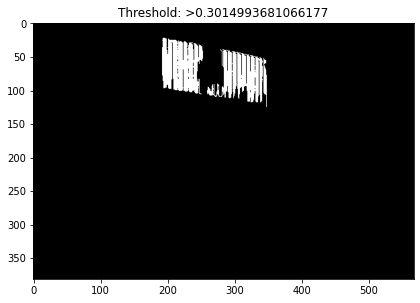

In [6]:
from skimage import filters


# Setting plot size to 15, 15
plt.figure(figsize=(15, 15))

# To gray
gray_container_masked = rgb2gray(container_masked)

# Computing Otsu's thresholding value
threshold = filters.threshold_otsu(gray_container_masked)

# Computing binarized values using the obtained
# thresold
container_bw = (gray_container_masked > threshold)*1
plt.subplot(2,2,1)
plt.title("Threshold: >"+str(threshold))
# Displaying the binarized image
plt.imshow(container_bw, cmap = "gray")

In [7]:
from skimage import morphology

def multi_dil(im,num):
  for i in range(num):
      im = morphology.binary_dilation(im)
  return im

def multi_ero(im,num):
  for i in range(num):
      im = morphology.binary_erosion(im)
  return im

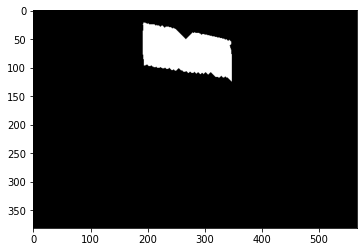

In [8]:
container_cleaned = multi_ero(multi_dil(container_bw,20),20)
plt.imshow(container_cleaned,cmap='gray')

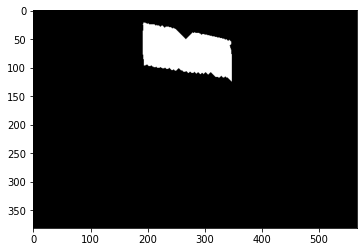

In [9]:
from skimage.segmentation import clear_border

# remove artifacts connected to image border
container_cleaned = clear_border(container_cleaned)
plt.imshow(container_cleaned,cmap='gray')

/home/juan/.virtualenvs/dl4cv/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


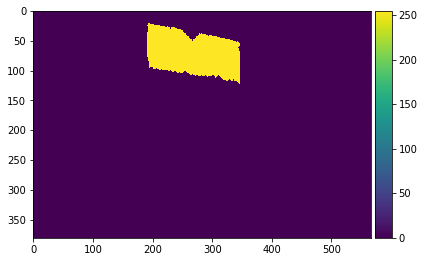

In [10]:
from skimage.measure import label, regionprops

clabel_im = label(container_cleaned)
imshow(clabel_im*255.0)

## Connected Components

Instead, we take a look at connected components as the focal point of interest in the analysis. An evident drawback of this approach is that it is heavily reliant on how clean the data is. Hence, the application of tweaking color spaces and the morphological operations would do the trick. See previous article about morphological operations if you're new to that term.

Before we can use the label and region_properties function of skimage of our
connected components, thorough image cleaning must be performed first. Below are
user-defined functions to do this:

We use this chain operation to clean the image:

Now that this is relatively clean, let us get the labels and properties of this image!

There are a lot of features that can be extracted from this labelled image. To mention a few we have:

Now, let’s use regionprops and look at the following properties:

  1. area
  2. perimeter
  3. bbox — bounding box dimensions
  4. bbox_area — area of bounding box
  5. centroid — coordinate of centroid
  6. convex_image — convex hull of the blob
  7. convex_area — area of the convex hull
  8. eccentricity — measure how it fits into an ellipse (0) for circles (how elongated is your object)
  9. major_axis_length — length of the major moment of the ellipse fitted
  10. minor_axis_length — length of the minor moment of the ellipse fitted

Let us try to take the area of the first object:

In [11]:
props=regionprops(clabel_im)

print(len(props))

props[0].area #area (zero) 0th object in the image
props[0].bbox

1


(22, 192, 125, 348)

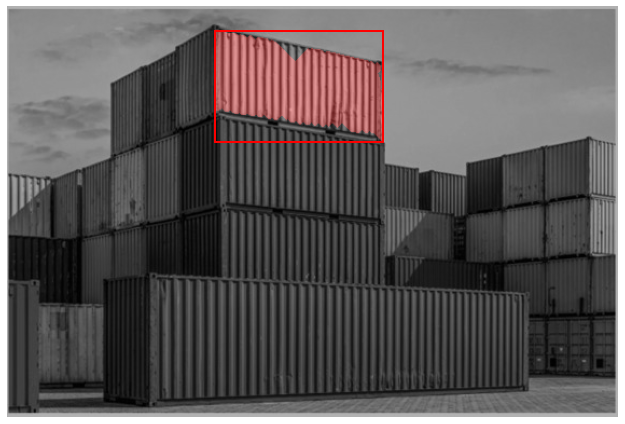

In [12]:
import matplotlib.patches as mpatches

# label image regions
label_container_regions = label(clabel_im)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
container_label_overlay = label2rgb(label_container_regions, 
                                    image=container, 
                                    bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(container_label_overlay)

for region in regionprops(label_container_regions):
    # take regions with large enough areas
    if region.area >= 200:
        # draw rectangle around segmented object
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), 
                                  maxc - minc, 
                                  maxr - minr,
                                  fill=False, 
                                  edgecolor='red', 
                                  linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()